In [ ]:
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import io
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset,DatasetDict
from transformers import AutoImageProcessor,ViTForImageClassification,TrainingArguments,Trainer
import evaluate

In [ ]:
data=load_dataset('pcuenq/oxford-pets')
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-ecc2afb43dedd5(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [ ]:
data['train'][29]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/leonberger_103.jpg',
 'label': 'leonberger',
 'dog': True,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>}

In [ ]:
labels=data['train'].unique('label')
len(labels)

37

In [ ]:
labels

['Siamese',
 'Birman',
 'shiba inu',
 'staffordshire bull terrier',
 'basset hound',
 'Bombay',
 'japanese chin',
 'chihuahua',
 'german shorthaired',
 'pomeranian',
 'beagle',
 'english cocker spaniel',
 'american pit bull terrier',
 'Ragdoll',
 'Persian',
 'Egyptian Mau',
 'miniature pinscher',
 'Sphynx',
 'Maine Coon',
 'keeshond',
 'yorkshire terrier',
 'havanese',
 'leonberger',
 'wheaten terrier',
 'american bulldog',
 'english setter',
 'boxer',
 'newfoundland',
 'Bengal',
 'samoyed',
 'British Shorthair',
 'great pyrenees',
 'Abyssinian',
 'pug',
 'saint bernard',
 'Russian Blue',
 'scottish terrier']

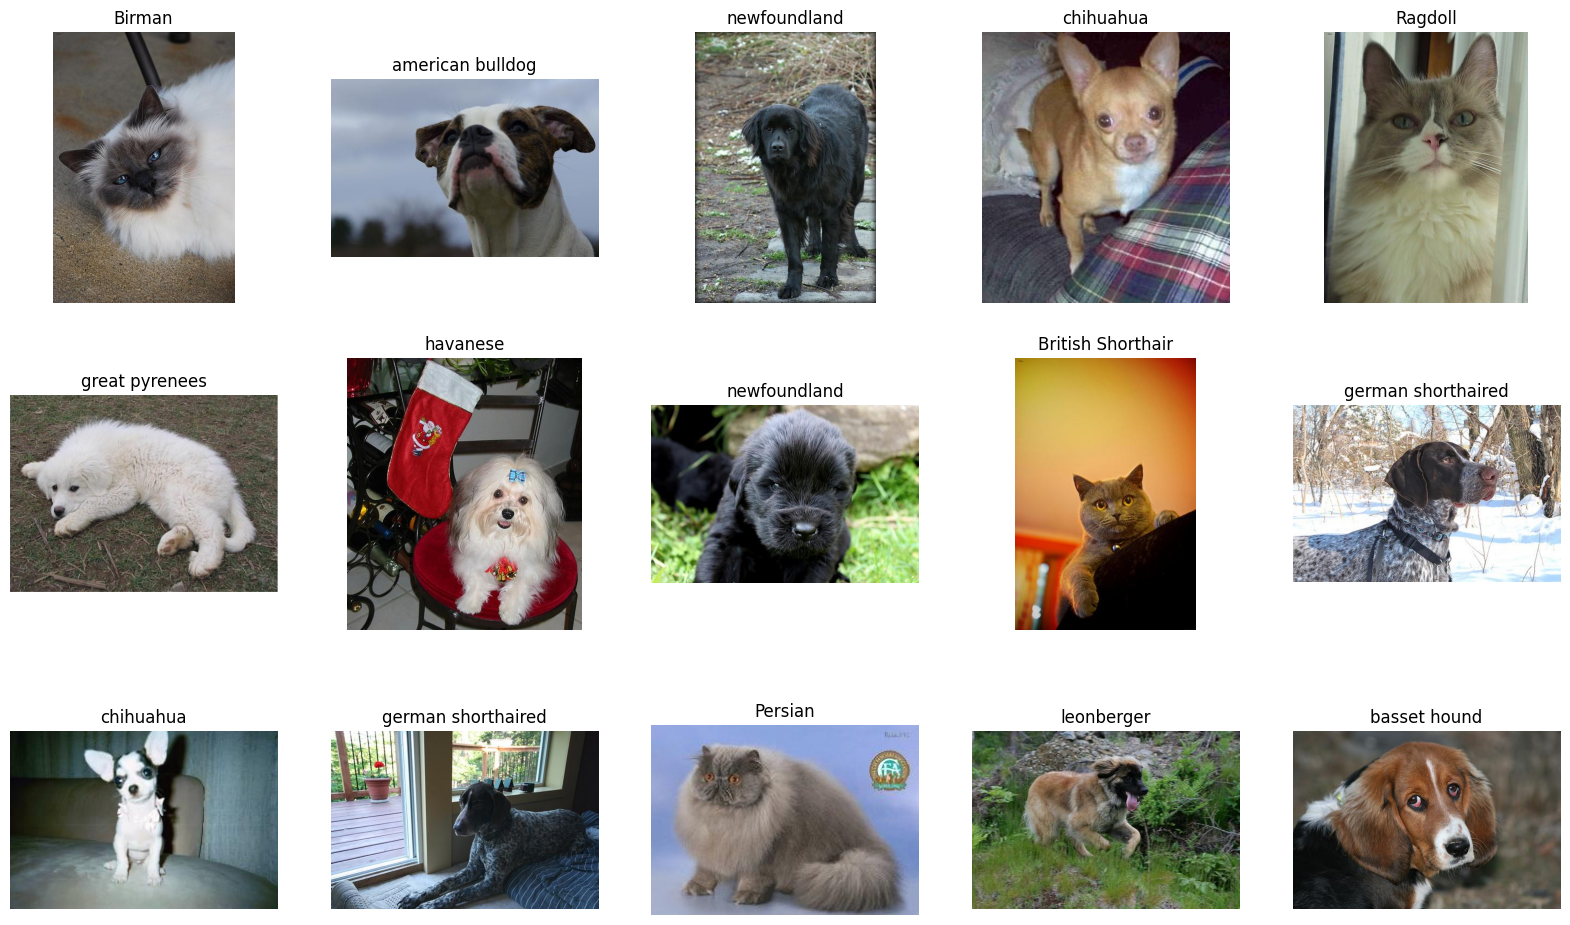

In [ ]:
def samples(data,r,c):
  sample=data.shuffle().select(np.arange(r*c))
  fig=plt.figure(figsize=(c*4,r*4))
  for i in range(r*c):
    imgb=sample[i]['image']
    label=sample[i]['label']
    fig.add_subplot(r,c,i+1)
    plt.imshow(imgb)
    plt.title(label)
    plt.axis('off')
samples(data['train'],3,5)

In [ ]:
split_data=data['train'].train_test_split(test_size=0.2)
eval_data=split_data['test'].train_test_split(test_size=0.5)

In [ ]:
dataset=DatasetDict({
    'train':split_data['train'],
    'validation':eval_data['train'],
    'test':eval_data['test']
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [ ]:
label2id={c:idx for idx,c in enumerate(labels)}
id2label={idx:c for idx,c in enumerate(labels)}

In [ ]:
processor=AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def transformations(batch):
  batch['image']=[x.convert('RGB') for x in batch['image']]
  inp=processor(batch['image'],return_tensors='pt')
  inp['labels']=[label2id[y] for y in batch['label']]
  return inp

In [ ]:
pdata=dataset.with_transform(transformations)

In [ ]:
def collation(batch):
  return{
      'pixel_values':torch.stack([x['pixel_values'] for x in batch]),
      'labels':torch.tensor([x['labels'] for x in batch])
  }

In [ ]:
accuracy=evaluate.load('accuracy')
def metrics(eval_preds):
  logits,labels=eval_preds
  preds=np.argmax(logits,axis=1)
  score=accuracy.compute(predictions=preds,references=labels)
  return score

In [ ]:
model=ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name,p in model.named_parameters():
  if not name.startswith('classifier'):
    p.requires_grad=False

In [ ]:
args=TrainingArguments(
    output_dir='./oxford-iiit-pets-vit',
    per_device_train_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True
)

In [ ]:
trainer=Trainer(
    model=model,
    args=args,
    data_collator=collation,
    compute_metrics=metrics,
    train_dataset=pdata['train'],
    eval_dataset=pdata['validation'],
    tokenizer=processor
)

/tmp/ipython-input-1124656383.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bhalaniakshat (bhalaniakshat-dwarkadas-j-sanghvi-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.366400,0.309457,0.916103
2,0.213100,0.242856,0.930988
3,0.169200,0.219394,0.936401
4,0.142800,0.211994,0.935047
5,0.140100,0.209943,0.935047


TrainOutput(global_step=1850, training_loss=0.3083921141237826, metrics={'train_runtime': 589.2781, 'train_samples_per_second': 50.163, 'train_steps_per_second': 3.139, 'total_flos': 2.2913817801515827e+18, 'train_loss': 0.3083921141237826, 'epoch': 5.0})

In [ ]:
trainer.evaluate(pdata['test'])

{'eval_loss': 0.1834321767091751,
 'eval_accuracy': 0.9364005412719891,
 'eval_runtime': 10.6486,
 'eval_samples_per_second': 69.398,
 'eval_steps_per_second': 8.734,
 'epoch': 5.0}

In [ ]:
trainer.save_model('./basic_vit_transferLearning')
processor.save_pretrained('./basic_vit_transferLearning')

['./basic_vit_transferLearning/preprocessor_config.json']

In [ ]:
from huggingface_hub import login

In [ ]:
login()

In [ ]:
trainer.push_to_hub('ByteMeHarder/basic_vit_transferLearning')

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ets-vit/model.safetensors:   7%|7         | 25.2MB /  343MB            

  ...638154.545195615ec3.320.0:   3%|3         |   416B / 12.5kB            

  ...638754.545195615ec3.320.1:   3%|3         |  13.0B /   411B            

  ...ets-vit/training_args.bin:   3%|3         |   193B / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/ByteMeHarder-404/oxford-iiit-pets-vit/commit/0b8b73338a086c32159ca379489d15cfd2640571', commit_message='ByteMeHarder/basic_vit_transferLearning', commit_description='', oid='0b8b73338a086c32159ca379489d15cfd2640571', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ByteMeHarder-404/oxford-iiit-pets-vit', endpoint='https://huggingface.co', repo_type='model', repo_id='ByteMeHarder-404/oxford-iiit-pets-vit'), pr_revision=None, pr_num=None)